<a href="https://colab.research.google.com/github/ishriana/Cohort-Analysis-/blob/main/Cohort_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Cohort Analysis Using Python***

What is Cohort and Cohort Analysis?

A cohort is a collection of users who have something in common. A traditional cohort, for example, divides people by the week or month of which they were first acquired. When referring to non-time-dependent groupings, the term segment is often used instead of the cohort.

Cohort analysis is a descriptive analytics technique in cohort analysis. Customers are divided into mutually exclusive cohorts, which are then tracked over time. Vanity indicators don’t offer the same level of perspective as cohort research. It aids in the deeper interpretation of high-level patterns by supplying metrics around the product and consumer lifecycle.

Generally, there are three major types of Cohort:

Time cohorts: customers who signed up for a product or service during a particular time frame.
Behavior cohorts: customers who purchased a product or subscribed to service in the past.
Size cohorts: refer to the various sizes of customers who purchase the company’s products or services.


Objectives:

1. Finding the percentage of active customers compared to the total number of customers after each month: Customer Segmentations
2. Interpret the retention rate

# Loading and Cleaning Data

In [83]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
df = pd.read_excel('/content/transaction.xlsx')
df.tail()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
19995,19996,51,1018,2017-06-24,1.0,Approved,OHM Cycles,Standard,high,medium,2005.66,1203.40,37823.0
19996,19997,41,127,2017-11-09,1.0,Approved,Solex,Road,medium,medium,416.98,312.74,35560.0
19997,19998,87,2284,2017-04-14,1.0,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,40410.0
19998,19999,6,2764,2017-07-03,0.0,Approved,OHM Cycles,Standard,high,medium,227.88,136.73,38216.0
19999,20000,11,1144,2017-09-22,1.0,Approved,Trek Bicycles,Standard,medium,small,1775.81,1580.47,36334.0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

We have 5 columns which are object type, 1 datetime column and the remaining float and int.

Next we ll check for missing values

In [36]:
#df.isnull().sum()

In [37]:
df.describe()

,transaction_id,product_id,customer_id,online_order,list_price,standard_cost,product_first_sold_date
count,20000.000000,20000.00000,20000.000000,19640.000000,20000.000000,19803.000000,19803.000000
mean,10000.500000,45.36465,1738.246050,0.500458,1107.829449,556.046951,38199.776549
std,5773.647028,30.75359,1011.951046,0.500013,582.825242,405.955660,2875.201110
min,1.000000,0.00000,1.000000,0.000000,12.010000,7.210000,33259.000000
25%,5000.750000,18.00000,857.750000,0.000000,575.270000,215.140000,35667.000000
50%,10000.500000,44.00000,1736.000000,1.000000,1163.890000,507.580000,38216.000000
75%,15000.250000,72.00000,2613.000000,1.000000,1635.300000,795.100000,40672.000000
max,20000.000000,100.00000,5034.000000,1.000000,2091.470000,1759.850000,42710.000000


Some inferences from the codes above are:
1. we have some nan values in our dataset we will have to deal with them first
2. from describe we can see that the dataset is pretty much balanced with the range starting from 0 or 1 in most of the cases median being somewhere having a central value of that column and max being around 2000.
3. standard deviation is high for transaction id and customer id as compared to other columns which is justified.

In [38]:
df['online_order'] = df['online_order'].ffill()

In [39]:
df['brand'] = df['brand'].bfill()

In [40]:
df['product_line'] = df['product_line'].ffill()

In [41]:
df['product_class'] = df['product_class'].bfill()

In [42]:
df['product_size'] = df['product_size'].bfill()

Since standard cost column has repeating values i will prefer forward fill instead of going with mean median or mode for this numeric column

In [43]:
df['standard_cost'] = df['standard_cost'].ffill()

In [44]:
df['product_first_sold_date'].mean()

38199.77654900773

Product sold date column has values between 33000 - 42000 and the distribution of values in this column look pretty uniform so we will fill the nan values by mean here

In [45]:
df['product_first_sold_date'] = df['product_first_sold_date'].mean()

Here we have finished dealing with missing values in our data.

In [46]:
df = df.replace(' ',np.NAN)

In [47]:
df = df.set_index(df['transaction_id'])

In [48]:
def get_month(x): 
  return dt.datetime(x.year, x.month, 1)

In [49]:
df['transmonth'] = df['transaction_date'].apply(get_month)

In [50]:
grp_by_tran_month = df.groupby('customer_id')['transmonth']

In [51]:
df['cohort_month'] = grp_by_tran_month.transform('min')

In [52]:
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,transmonth,cohort_month
transaction_id,,,,,,,,,,,,,,,
1,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,38199.776549,2017-02-01,2017-02-01
2,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,38199.776549,2017-05-01,2017-01-01
3,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,38199.776549,2017-10-01,2017-01-01
4,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,38199.776549,2017-08-01,2017-02-01
5,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,38199.776549,2017-10-01,2017-01-01


In [53]:
def date_info(df,column):
  year = df[column].dt.year
  month = df[column].dt.month
  day = df[column].dt.day
  return year, month, day

In [54]:
year_trans , month_trans, day_trans = date_info(df,'transmonth')

In [55]:
cohort_yr , cohort_month, cohort_day = date_info(df, 'cohort_month')

In [56]:
diff_yrs = year_trans - cohort_yr
diff_months = month_trans - cohort_month
diff_day = day_trans - cohort_day

In [57]:
df['cohort_index'] = diff_yrs * 12 + diff_months + 1

We ll count daily active users from each cohort

In [59]:
grouping = df.groupby(['cohort_month', 'cohort_index'])
cohort_data = grouping['customer_id'].apply(pd.Series.nunique)

In [60]:
cohort_data

cohort_month  cohort_index
2017-01-01    1               1354
              2                486
              3                508
              4                509
              5                502
                              ... 
2017-10-01    2                  6
              3                  8
2017-11-01    1                 13
              2                  5
2017-12-01    1                  4
Name: customer_id, Length: 78, dtype: int64

In [63]:
cohort_data = cohort_data.reset_index()

In [65]:
cohort_counts = cohort_data.pivot(index='cohort_month',
                                  columns= 'cohort_index',
                                  values= 'customer_id')

In [68]:
cohort_data

,cohort_month,cohort_index,customer_id
0,2017-01-01,1,1354
1,2017-01-01,2,486
2,2017-01-01,3,508
3,2017-01-01,4,509
4,2017-01-01,5,502
...,...,...,...
73,2017-10-01,2,6
74,2017-10-01,3,8
75,2017-11-01,1,13
76,2017-11-01,2,5


In [67]:
cohort_counts

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2017-01-01,1354.0,486.0,508.0,509.0,502.0,483.0,518.0,529.0,500.0,531.0,497.0,516.0
2017-02-01,800.0,325.0,298.0,313.0,288.0,298.0,308.0,281.0,329.0,308.0,296.0,NaN
2017-03-01,484.0,167.0,174.0,167.0,182.0,184.0,172.0,212.0,189.0,181.0,NaN,NaN
2017-04-01,336.0,111.0,121.0,153.0,143.0,121.0,142.0,126.0,132.0,NaN,NaN,NaN
2017-05-01,210.0,85.0,81.0,87.0,71.0,74.0,73.0,81.0,NaN,NaN,NaN,NaN
2017-06-01,122.0,45.0,44.0,47.0,46.0,46.0,53.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,77.0,26.0,29.0,32.0,37.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,51.0,19.0,21.0,17.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,23.0,7.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [93]:
retention

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2017-01-01,1.0,0.358936,0.375185,0.375923,0.370753,0.356721,0.382570,0.390694,0.369276,0.392171,0.367061,0.381093
2017-02-01,1.0,0.406250,0.372500,0.391250,0.360000,0.372500,0.385000,0.351250,0.411250,0.385000,0.370000,NaN
2017-03-01,1.0,0.345041,0.359504,0.345041,0.376033,0.380165,0.355372,0.438017,0.390496,0.373967,NaN,NaN
2017-04-01,1.0,0.330357,0.360119,0.455357,0.425595,0.360119,0.422619,0.375000,0.392857,NaN,NaN,NaN
2017-05-01,1.0,0.404762,0.385714,0.414286,0.338095,0.352381,0.347619,0.385714,NaN,NaN,NaN,NaN
2017-06-01,1.0,0.368852,0.360656,0.385246,0.377049,0.377049,0.434426,NaN,NaN,NaN,NaN,NaN
2017-07-01,1.0,0.337662,0.376623,0.415584,0.480519,0.311688,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,1.0,0.372549,0.411765,0.333333,0.254902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,1.0,0.304348,0.304348,0.391304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
retention.round(2)*100

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2017-01-01,100.0,36.0,38.0,38.0,37.0,36.0,38.0,39.0,37.0,39.0,37.0,38.0
2017-02-01,100.0,41.0,37.0,39.0,36.0,37.0,38.0,35.0,41.0,38.0,37.0,NaN
2017-03-01,100.0,35.0,36.0,35.0,38.0,38.0,36.0,44.0,39.0,37.0,NaN,NaN
2017-04-01,100.0,33.0,36.0,46.0,43.0,36.0,42.0,38.0,39.0,NaN,NaN,NaN
2017-05-01,100.0,40.0,39.0,41.0,34.0,35.0,35.0,39.0,NaN,NaN,NaN,NaN
2017-06-01,100.0,37.0,36.0,39.0,38.0,38.0,43.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,100.0,34.0,38.0,42.0,48.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,100.0,37.0,41.0,33.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,100.0,30.0,30.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


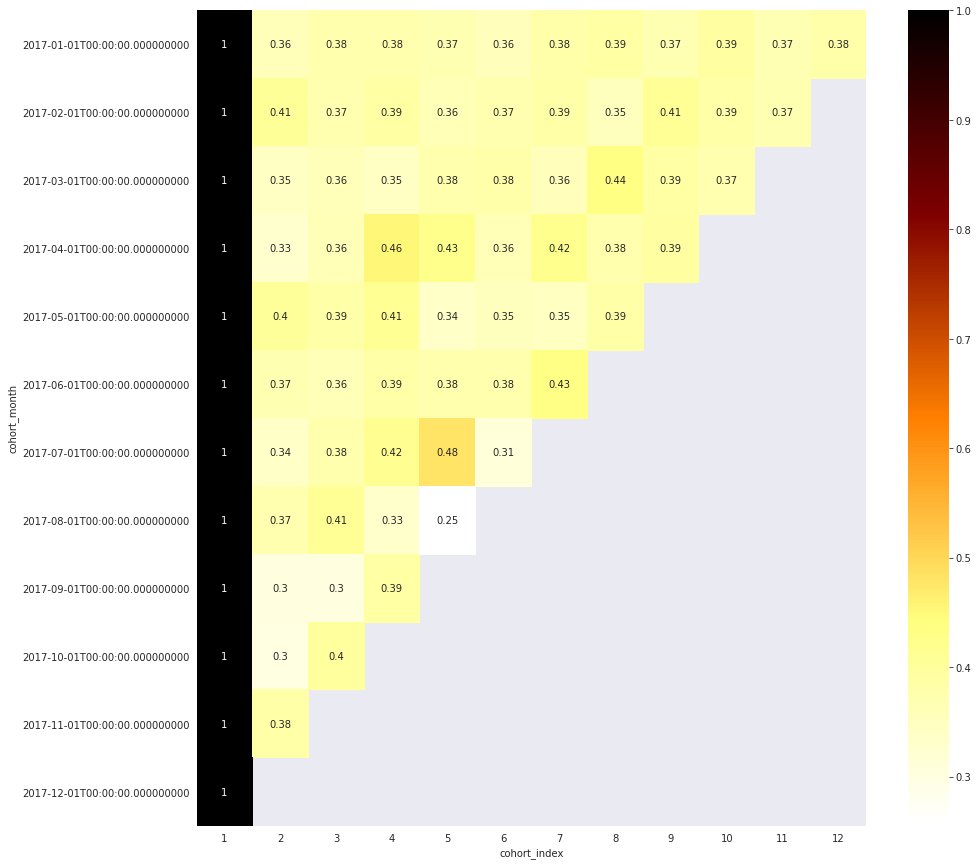

In [86]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,15))
sns.heatmap(retention,annot=True,cmap='afmhot_r')

Index of retention is way to big. We ll change it to a small form

In [94]:
retention.index = retention.index.strftime('%y-%m')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]), <a list of 12 Text major ticklabel objects>)

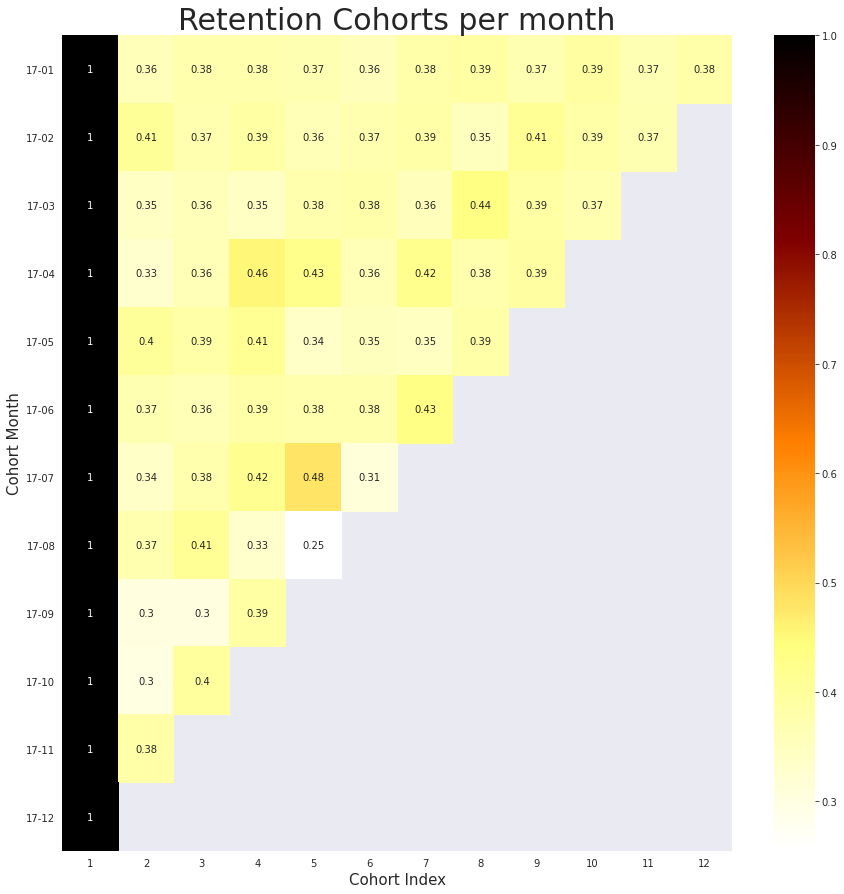

In [99]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,15))
sns.heatmap(retention,annot=True,cmap='afmhot_r')
plt.xlabel('Cohort Index', fontsize=15)
plt.ylabel('Cohort Month',fontsize=15)
plt.title('Retention Cohorts per month', fontsize=30)
plt.yticks(rotation='360')